<a href="https://colab.research.google.com/github/yprift01/4chan-data-project/blob/main/jupyter/4chan-topic-modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
%%capture
# needed to support mongo+srv connection strings
## Only run once per kernel environment
## Doesn't need to be re-run when kernel is restarted

!pip install dnspython
!pip install pymongo[srv]
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install scipy
!pip install gensim
!pip install langdetect
!pip install tqdm
!pip install nltk
!pip install seaborn
!pip install pyLDAvis
!pip install wordcloud




In [1]:
## Only run once per kernel environment
## Doesn't need to be re-run when kernel is restarted

import nltk
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('wordnet')
#nltk.download('stopwords')

In [2]:
%%capture


from pymongo import MongoClient
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# Fixed period analysis - change these to extend/restrict the period
# Date as a yyyymmddhhMMss string
date_from = '20210501000000'
date_to =   '20211101000000'

# connectiong to mongodb cluster using a read only user

## REMOTE REPLICA SET
client = MongoClient("mongodb+srv://<usr>:<pass>@rs.prifti.us/?ssl=false&authSource=chan")

## LOCAL SINGLE INSTANCE
## 192.168.1.110 -- localhost
# client = MongoClient("mongodb://<usr>:<pass>@localhost:27777/?ssl=false&serverSelectionTimeoutMS=5000&connectTimeoutMS=10000&authSource=chan&authMechanism=SCRAM-SHA-256")

# connection to chan database
db = client.chan

# the threads collection contains API data collections from the 4chan api and 4pleb api
threads_collection = db['y-threads']


In [3]:
from datetime import datetime as dt

date_format = "%Y%m%d%H%M%S"
dt_to = dt.strptime(date_to, date_format)
dt_from = dt.strptime(date_from, date_format)
nr_days = (dt_to - dt_from).days - 1
print(nr_days)

instances_pipeline = [ 
    {"$match": { "$or": [ 
                    { "url": {"$eq": "https://boards.4chan.org/pol/thread/124205675" }}
                   ,{ "url": {"$eq": "https://boards.4chan.org/pol/thread/!!!259848258!!!" }}
                    ] } }
    ,{"$project": {"_id": 1, "scans": 1, "last_scan": {"$last": "$scans"},
                   "first_scan": {"$first": "$scans"}, "url": 1 } }
    ,{"$unwind": "$scans"}
    ,{"$match": { "$and": [ { "scans": {"$gt": date_from } }, 
                            { "scans": {"$lt": date_to } } ] } }
    ,{"$sort": {"last_scan": -1 } }
]

# the 'live-4chan' collection contains the OXPath data collection
livechan = db['y-live-4chan']
instances_dataset = pd.DataFrame(livechan.aggregate(instances_pipeline, allowDiskUse=True))



183


In [5]:
instances_dataset['scans_dt'] = instances_dataset['scans'].apply(lambda x: x[0:10])
#instances_dataset['scans_dt']

len(instances_dataset)

300226

In [6]:
count_dataset = instances_dataset[['scans_dt']].copy()
count_dataset.set_index('scans_dt', drop=False, inplace=True)
count_dataset = count_dataset['scans_dt'].groupby(['scans_dt']).count()
count_dataset.index.names = ['scans']
count_dataset = count_dataset.reset_index()
count_dataset.columns = ['scans', 'count']

#count_dataset = pd.DataFrame([count_dataset.index, count_dataset.values])



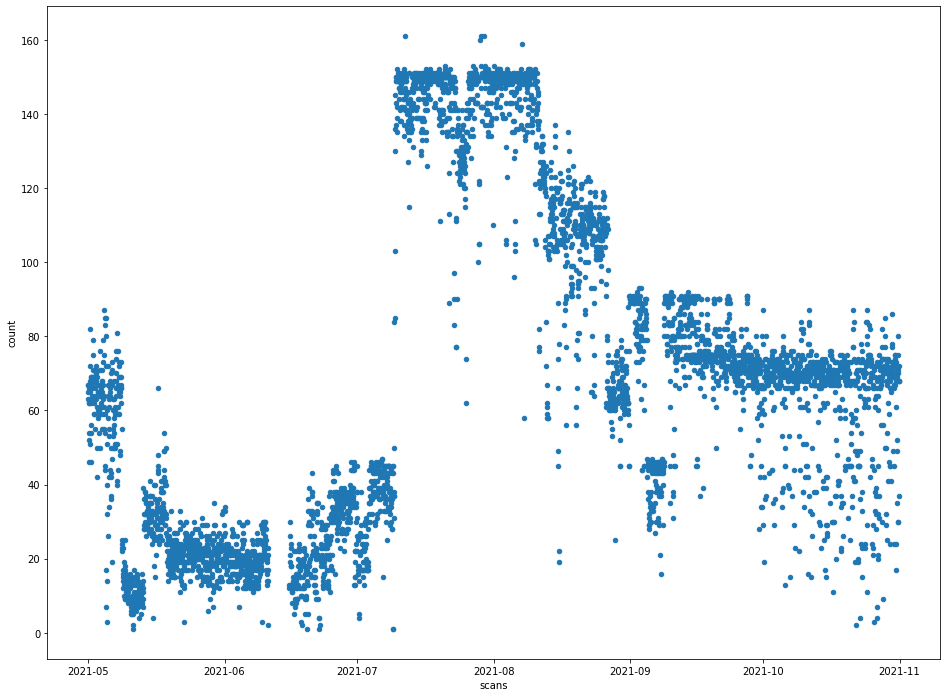

In [7]:
plt.rcParams["figure.figsize"] = (16,12)

count_dataset['scans'] = pd.to_datetime(count_dataset['scans'], format = "%Y%m%d%H")
count_dataset.plot(kind='scatter', x = 'scans', y='count')
pass


In [34]:
import pandas as pd

pipeline = []; 
date_from = '202105010000'
date_to =   '202111010000'
threads_collection = "y-threads"
live_collection = "y-live-4chan"

threads_with_extraction_issues = [
    "https://boards.4chan.org/pol/thread/326366274", 
    "https://boards.4chan.org/pol/thread/325011138", 
    "https://boards.4chan.org/pol/thread/326104380", 
    "https://boards.4chan.org/pol/thread/325011942", 
    "https://boards.4chan.org/pol/thread/321358705",
    "https://boards.4chan.org/pol/thread/320954471",
    "https://boards.4chan.org/pol/thread/320954747", 
    "https://boards.4chan.org/pol/thread/320918144", 
    "https://boards.4chan.org/pol/thread/320954727", 
    "https://boards.4chan.org/pol/thread/321222545", 
    "https://boards.4chan.org/pol/thread/321221897", 
    "https://boards.4chan.org/pol/thread/321224228", 
    "https://boards.4chan.org/pol/thread/321222262", 
    "https://boards.4chan.org/pol/thread/321224335", 
    "https://boards.4chan.org/pol/thread/321221936", 
    "https://boards.4chan.org/pol/thread/321223900", 
    "https://boards.4chan.org/pol/thread/321223056", 
    "https://boards.4chan.org/pol/thread/321095251", 
    "https://boards.4chan.org/pol/thread/321026821", 
    "https://boards.4chan.org/pol/thread/320954432", 
    "https://boards.4chan.org/pol/thread/321221773",
    "https://boards.4chan.org/pol/thread/321137429",
    "https://boards.4chan.org/pol/thread/320989621"
]


#exclude threads with issues
exclude_threads   =  { "$match": { "url": {"$nin": threads_with_extraction_issues } } }

# normalise nulls in $data 
remove_scrap_errors =  { "$addFields": { "data": { "$cond": [
                {"$and":[ {"$gt": ["$data", None] }, {"data": {"$type": "array"} } ] }, "$data", [{ }]  
              ] } } };
              
# only load required fields from 'live-4chan' collection
live_4chan_projection = { "$project": { "_id": 0, "url": 1 
                    ,"first_scan": {"$arrayElemAt": ["$scans", 0 ] }
                    ,"last_scan": {"$arrayElemAt": ["$scans", -1 ] }
                    ,"oxp_op": { "$arrayElemAt": [ "$data", -1 ] } 
                  }
    };


# limit the data to fixed period
filter_by_date = { "$match": {"$and":[ {"first_scan": { "$gt": date_from} }, {"last_scan": { "$lt": date_to }} ] } };


# join with the threads collection for PLEB and 4CHAN api data
threads_lookup = { "$lookup": { 
               "from": threads_collection,
               "localField": "url",
               "foreignField": "_id",
               "as": "api_thread"
       }
    };


# unwind/expand the joined array 
unwind_api_thread =  { "$unwind": "$api_thread" };

# remove items where the API scrap job has not been performed
# this should only affects threads that have not been archived/deleted yet 
filter_no_api_scrap = { "$match": { "api_thread.api_scrap": True } };

# include the op thread scaped via 4Chan API
add_chan_api =  { "$addFields": { "chan_op": { "$cond": [
        {"$and":[ {"$gt": ["$api_thread.chan.posts", None] }] }, "$api_thread.chan.posts", [{ }]  
      ] } } };
      
      
# add the boolean fields that check if chan api fields has data
project_booleans =  { "$project": { "_id": 0, "url": 1
                    ,"oxp_op": "$oxp_op.payload"
                   # ,"chan_op": {"$arrayElemAt": ["$chan_op", 0]}
                   # ,"chan_replies": { "$ifNull": ["$chan_op", [ ]] }
                   # ,"chan": {"$gt": [ "$api_thread.chan.posts", { } ] }
                   # ,"pleb": "$api_thread.pleb" 
        } 
   };
   
#// unwind the array of data from OXPath Scrap   
unwind_oxp_op = {"$unwind": {"path": "$oxp_op", "preserveNullAndEmptyArrays": True } };

#//  # convert a document to array to better check relevant fields have values
add_pleb_api_field = { "$addFields": {
        "pleb_array": {
                "$ifNull": [ {"$objectToArray": "$pleb"}, [ ] ] 
          }
     } 
   };


# bring array fields one level up
unwind_pleb_array =  { "$unwind": { "path": "$pleb_array", "preserveNullAndEmptyArrays": True } };


# project result (OXP_RPLIES & OXP_NR_REPLIES)
project_final_result =   { "$project": { "_id": 0, "url": 1, "last_scan": 1
                  ,"oxp_op":"$oxp_op.thread.op"
                  ,"oxp_replies": { "$ifNull": ["$oxp_op.thread.replies", [] ] }
                  ,"oxp": { "$gt": ["$oxp_op", { }] }
              #    ,"chan": 1 
              #    ,"chan_op": 1 
              #    ,"chan_replies":  { "$cond": { "if": { "$gt": [ {"$size": "$chan_replies"}, 1 ] }, "then": {"$slice": ["$chan_replies", 1, {"$size": "$chan_replies"} ] }, "else": [ ] } }
              #    ,"pleb_op": "$pleb_array.v.op"
              #    ,"pleb_replies": { "$ifNull": [{"$objectToArray": "$pleb_array.v.posts"}, [ ]]}  
              #    ,"pleb": { "$gt": [ "$pleb_array.v.op", { } ] } 
              }
   };

#//unwind twice the OXPATH array
unwind_oxpath_array1 =  { "$unwind": {"path": "$oxp_op", "preserveNullAndEmptyArrays": True } };
unwind_oxpath_array2 =  { "$unwind": {"path": "$oxp_op", "preserveNullAndEmptyArrays": True } };
unwind_oxpath_reply_array =  { "$unwind": {"path": "$oxp_replies", "preserveNullAndEmptyArrays": True } };

oxp_replies_array_projection = {"$project":  { "_id": 0, "url": 1
                                     ,"oxp_replies": 1 
                                     ,"oxp_replies_r": {
                                         "$map": {
                                             "input":  "$oxp_replies",
                                             "as": "r",
                                             "in": { 
                                                   "authorid": "$$r.reply.authorid"
                                                  ,"message":"$$r.reply.message"
                                                  ,"post_number": "$$r.reply.post_number"
                                             }
                                         }
                                     } 
                                }
                            }

unwind_reply_array_auth_1 =  { "$unwind": {"path": "$oxp_replies_r.authorid", "preserveNullAndEmptyArrays": True } };
unwind_reply_array_auth_2 =  { "$unwind": {"path": "$oxp_replies_r.authorid", "preserveNullAndEmptyArrays": True } };

unwind_reply_array_msg_1 =  { "$unwind": {"path": "$oxp_replies_r.message", "preserveNullAndEmptyArrays": True } };
unwind_reply_array_msg_2 =  { "$unwind": {"path": "$oxp_replies_r.message", "preserveNullAndEmptyArrays": True } };

unwind_reply_array_pnr_1 =  { "$unwind": {"path": "$oxp_replies_r.post_number", "preserveNullAndEmptyArrays": True } };
unwind_reply_array_pnr_2 =  { "$unwind": {"path": "$oxp_replies_r.post_number", "preserveNullAndEmptyArrays": True } };

filter_only_three_way_match = { "$match": {"oxp": True, "pleb": True, "chan": True} }
revers_sort_by_last_scan =  { "$sort": {"last_scan": -1} };
size_output_groupping = { "$group": { "_id": None, "count": {"$sum" : 1}} }
output_limit = {"$limit": 100}

pipeline.append(exclude_threads);
pipeline.append(remove_scrap_errors);
pipeline.append(live_4chan_projection);
pipeline.append(filter_by_date);
#pipeline.append(threads_lookup);
#pipeline.append(unwind_api_thread);
#pipeline.append(filter_no_api_scrap);
#pipeline.append(add_chan_api);
pipeline.append(project_booleans);
pipeline.append(unwind_oxp_op);
#pipeline.append(add_pleb_api_field);
#pipeline.append(unwind_pleb_array);
pipeline.append(project_final_result);
pipeline.append(unwind_oxpath_array1);
pipeline.append(unwind_oxpath_array2);
pipeline.append(unwind_oxpath_reply_array);
pipeline.append(oxp_replies_array_projection);

pipeline.append(unwind_reply_array_auth_1)
pipeline.append(unwind_reply_array_auth_2)
    
pipeline.append(unwind_reply_array_msg_1)
pipeline.append(unwind_reply_array_msg_2)

pipeline.append(unwind_reply_array_pnr_1)
pipeline.append(unwind_reply_array_pnr_2)
    
#pipeline.append(filter_only_three_way_match);
#//pipeline.append(revers_sort_by_last_scan);
#//pipeline.push(size_output_groupping);
pipeline.append(output_limit)

match_result = pd.DataFrame(db[live_collection].aggregate(pipeline, allowDiskUse = True)) 


In [1]:
match_result

NameError: ignored